In [1]:
"""
All necessary imports
"""

import math
import csv

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.spatial.distance as distance
import scipy

from pandas import read_csv
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from minepy import MINE

import matplotlib.pyplot as plt
import seaborn
from mrmr import mrmr_classif
import pprint
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

from mendeleev import element
from mendeleev.fetch import fetch_table
import pandas as pd
import time
import ast
import re

In [2]:
converters = {
    'elem_in_site_order': ast.literal_eval,
    'elem_by_formula_order': ast.literal_eval,
    'num_electrons': ast.literal_eval,
    'eaffinity': ast.literal_eval,
    'dipole': ast.literal_eval,
    'covalent_rad': ast.literal_eval,
    'atomic_vol': ast.literal_eval,
    'atomic_rad': ast.literal_eval,
    'A1': ast.literal_eval,  # Converter for column 'A1'
    'A2': ast.literal_eval,  # Converter for column 'A2'
    'B1': ast.literal_eval,  # Converter for column 'B1'
    'B2': ast.literal_eval,  # Converter for column 'B2'
    'X': ast.literal_eval,   # Converter for column 'X'
}

df2 = pd.read_csv('maxrad.csv', converters=converters)


In [3]:
pd.set_option('display.max_columns', None)
df = df2
#display(df.head(1))

#print(df['A1'])
print(type(df.head(1)['A1']))
print(df.head(1)['A1'][0]['atomic_rad'])

#remove 21 faulty materials
df = df[df['X'] != {}]
#display(df.iloc[55:66])

print(df['atomic_rad'].head(3))

<class 'pandas.core.series.Series'>
130.0
0    [130.0, 125.0, 137.0, 160.0, 128.0]
1           [130.0, 125.0, 137.0, 160.0]
2    [130.0, 125.0, 132.0, 137.0, 160.0]
Name: atomic_rad, dtype: object


In [4]:
"""
manually compute and use standardscaler
"""


#add 1.0 properties###########################################
properties = ['atomic_rad', 'atomic_vol','dipole', 'eaffinity','covalent_rad', 'num_electrons']
sums = {}
tot_n = 0
for i in properties:
    cursum = 0
    num_data = 0
    for(index, row) in df.iterrows():  
        for j in row[i]:
            cursum+=j
            num_data+=1
    sums[i]= cursum
    tot_n = num_data
###########################################



#add maxSPD and nup###########################################
spdProps = ['maxS', 'maxP', 'maxD', 'n_up_single', 'n_val_single']
sites = ['A1', 'A2', 'B1', 'B2', 'X']
for i in spdProps:
    cursum = 0
    num_data = 0
    for(index, row) in df.iterrows(): 
        for j in sites:
            curcur = row[j][i]
            cursum+=curcur
            num_data +=1
     
    sums[i]= cursum
    tot_n = num_data
###########################################


averages = {}
for i in sums:
    averages[i] = sums[i] / tot_n
print("averages: ", averages)
#we have averages for each value, now pass through again to find std deviation

#1.0 stddevs###########################################
stddev = {}
for i in properties:
    square_diff_sum = 0
    for(index, row) in df.iterrows():  
        for j in row[i]:
            square_diff_sum += ((j-averages[i])**2)
    stddev[i] = math.sqrt( (square_diff_sum)/tot_n )
print("stddevs: ", stddev)
###########################################

#spd stddevs####################################
for i in spdProps:
    square_diff_sum = 0
    for(index, row) in df.iterrows():  
        for j in sites:
            square_diff_sum += ((row[j][i]-averages[i])**2)
    stddev[i] = math.sqrt( (square_diff_sum)/tot_n )
print("stddevs: ", stddev)
############################################

#now i have std deviation and mean for all properties, time to manually standard scaler
#scale the data stored in property order
for i in properties:
    for(index, row) in df.iterrows(): 
        curnew = [] 
        for j in row[i]:
            j = (j - averages[i])/stddev[i]
            curnew.append(j)

        df.at[index, i] = curnew
#display(df)

#now the property order is standard scaler'ed, time to do on site order

sites = ['A1', 'A2', 'B1', 'B2', 'X']
for i in sites:
    for(index, row) in df.iterrows(): 
        curnew = {} 
        for j in row[i]:
           #print(j)
            curnew[j] = (row[i][j] - averages[j])/stddev[j]
        #display(curnew)
        df.at[index, i] = curnew
#display(df['A1'])
       

averages:  {'atomic_rad': 130.4390243902439, 'atomic_vol': 12.255609756097536, 'dipole': 49.56606829268321, 'eaffinity': 1.0472338982829317, 'covalent_rad': 116.45463414634146, 'num_electrons': 33.33073170731707, 'maxS': 2.112599024390244, 'maxP': 1.8012468292682897, 'maxD': 1.8837980487804717, 'n_up_single': 2.5697560975609757, 'n_val_single': 5.098536585365854}
stddevs:  {'atomic_rad': 17.175269633168526, 'atomic_vol': 4.913615852383537, 'dipole': 25.0278338075077, 'eaffinity': 0.5548968979398397, 'covalent_rad': 14.288533070069413, 'num_electrons': 17.654129414190695}
stddevs:  {'atomic_rad': 17.175269633168526, 'atomic_vol': 4.913615852383537, 'dipole': 25.0278338075077, 'eaffinity': 0.5548968979398397, 'covalent_rad': 14.288533070069413, 'num_electrons': 17.654129414190695, 'maxS': 0.5626248485395698, 'maxP': 0.5948351889407196, 'maxD': 1.3483687312131079, 'n_up_single': 0.8388508045051414, 'n_val_single': 1.1807594930250813}


In [5]:
pd.set_option('display.max_colwidth', None)
def truncate_decimals(number):
    return round(number, 2)
print(df['atomic_rad'].apply(lambda x: [truncate_decimals(i) for i in x]).head(3))
pd.reset_option('display.max_colwidth')

0    [-0.03, -0.32, 0.38, 1.72, -0.14]
1           [-0.03, -0.32, 0.38, 1.72]
2     [-0.03, -0.32, 0.09, 0.38, 1.72]
Name: atomic_rad, dtype: object


In [6]:
dsct = {
    'P1': ['n_up_single', 'n_val_single',],
    'P2': ['atomic_rad', 'covalent_rad'],
    'P3': ['maxS', 'maxP', 'maxD'],
    'P3&Q3': ['P3', 'Q3+'],
    'C3' : ['C3'],
    'Q1&Q1': ['Q1+', 'Q1-'],
    'Q2&Q2': ['Q2+', 'Q2-'],
    'Q3&Q3': ['Q3+', 'Q3-'],
    'X1': [['P1', 'Q1+', 'Q1-'], ['P3', 'C3', 'D3', 'E3']],
    'X2': [['P2', 'Q2+', 'Q2-'], ['P3', 'C3', 'D3', 'E3']],
    'X3': [['P3', 'Q3+', 'Q3-'], ['P3', 'C3', 'D3', 'E3']],
}
def get_descripts(id):
    return(dsct[id])

In [8]:

#helper function to generate a descriptor and the label for it in Q class descriptors
def gen_single(pair, sign, row, descripts, i, j): 
    # i is which function to operate on pair[0]
    # j is which function (ie, EA vs IP) to operate on pair[1]
    if sign == '+':
        str1 = descripts[i] + pair[0] + "+" +descripts[j] + pair[1]# 0 0
        val1 = row[pair[0]][descripts[i]] + row[pair[1]][descripts[j]]
        return (str1, val1)
    elif sign == '-':
        str1 = descripts[i] + pair[0] + "-" +descripts[j] + pair[1]# 0 0
        val1 = abs(row[pair[0]][descripts[i]] - row[pair[1]][descripts[j]])
        return (str1, val1)

#add Q class descriptors, hard coded functionality for exactly 2 and 3 size P classes, there is a (n*n-1)/2 len function to generalize this, 
# but this would increase the number of descriptors by several times, when 80,000 is already pushing ram limits
def add_to_dict(dct, pair, sign, row, descripts):
    for i in range(len(descripts)):
        for j in range(len(descripts)):
            strn, valn = gen_single(pair, sign, row, descripts, i, j)
            dct[strn] = valn


    for i in range(2):
        if(len(descripts)==2):
            strn, valn = gen_single((pair[i], pair[i]), sign, row, descripts, 0, 1)
            dct[strn] = valn
        elif(len(descripts)==3):
            for j in [[0,1], [0,2], [1,2]]:
                strn, valn = gen_single((pair[i], pair[i]), sign, row, descripts, j[0], j[1])
                dct[strn] = valn


def add_to_dict_cde(dct, row, descripts, sign):
    if sign == '**2':
        for o in descripts:
            for i in row[o]:
                strn = "(" + i + ")"+ "**2"
                valn = row[o][i] ** 2
                dct[strn] = valn
    elif sign == 'exp':
        for o in descripts:
            for i in row[o]:
                strn = "exp(" + i + ")"
                valn = math.exp(row[o][i])
                dct[strn] = valn
    elif sign == 'exp2':
        for o in descripts:
            for i in row[o]:
                strn = "exp(" + i + ")"
                valn = math.exp(row[o][i])
                dct[strn] = valn


#add the P (aka A) class descriptors to dictionary
def add_to_dict_Ps(dct, row, descripts):
    for i in descripts:
        for j in ['A1', 'A2', 'B1', 'B2', 'X']:
            strn = i + j 
            valn = row[j][i]
            dct[strn] = valn


def add_to_dict_f123(dct, row, descripts):
    for i in descripts:
        for j in descripts:
            for frst in row[i]:
                for snd in row[j]:
                    if(i!=j or frst != snd):
                        strn = "(" + frst + ")" + '+' +  "(" + snd + ")"
                        valn = row[i][frst] + row[j][snd]
                        dct[strn] = valn

def add_to_dict_x123(dct, row, descripts):
    numerators = descripts[0] 
    denominators = descripts[1]
    for i in numerators:
        for j in denominators:
            for frst in row[i]:
                for snd in row[j]:
                    if(i!=j or frst != snd):
                        strn = "(" + frst + ")" + '/' +  "(" + snd + ")"
                        valn = row[i][frst] + row[j][snd]
                        dct[strn] = valn



def calculate(pairlist, id, sign, row):
    """
    god function to add all descriptors to the dictionary

    pairlist: the 5 atom-atom interactions being computed in Q class
    id: a string used to get the list of descriptors used to generate this new class, either a base class like atomic radius, or a previously generated column like Q2+
    sign: the operator used to combine descriptors, effectively just a key to tell program which function to call for this class of descriptors
    row: the row in the dataset being added to
    """
    descripts = get_descripts(id)
    dct = {}
   
    if sign == '+' or sign== '-':
        for i in pairlist:
            add_to_dict(dct, i, sign, row, descripts)
    elif sign == '.':
        add_to_dict_Ps(dct, row, descripts)
    elif sign == '**2' or sign == 'exp' or sign == 'exp2':
        add_to_dict_cde(dct, row, descripts, sign)
    elif sign == '++':
        add_to_dict_f123(dct, row, descripts)
    elif sign == 'X':
        add_to_dict_x123(dct, row, descripts)
    return dct
    

In [9]:
cols_to_add = [['P1','P1', '.'],['P2','P2', '.'],['P3','P3', '.'],['Q1+','P1', '+'], 
               ['Q1-','P1', '-'], ['Q2+','P2', '+'],['Q2-','P2', '-'],
               ['Q3+','P3', '+'],['Q3-','P3', '-'],
               ['C3', 'P3&Q3', '**2'], ['D3', 'P3&Q3', 'exp'], ['E3', 'C3', 'exp2'] ,
               ['F1', 'Q1&Q1', '++'], ['F2', 'Q2&Q2', '++'], ['F3', 'Q3&Q3', '++'],
               ['X1', 'X1', 'X'],
               ['X2', 'X2', 'X'],
               ['X3', 'X3', 'X']
                ] # name, type, sign

pairs = [('A1', 'A2'),('A1', 'X'),('A2', 'X'),('B1', 'X'),('B2', 'X')]

for p in cols_to_add:
    df[p[0]] = [{} for _ in range(len(df))]

for c in cols_to_add:
    for(index, row) in df.iterrows():    
        tmp = calculate(pairs, c[1], c[2], row)
        df.at[index, c[0]] = tmp
        #print(c[0])

#outputs to help verify numbers are accurate between the _3 classes and the _2&_1 classes, since _3 has extra base descriptors now
display(df.head(1))
print(len(df.iloc[5]['P3']))
print(len(df.iloc[5]['P2']))
print(len(df.iloc[5]['Q3-']))
print(len(df.iloc[5]['Q2-']))
print(len(df.iloc[5]['F2']))
print(len(df.iloc[5]['F3']))
# print(len(df.iloc[5]['X1']))
# print(len(df.iloc[5]['X2']))
# print(len(df.iloc[5]['X3']))

,Unnamed: 0,formation_energy,elem_frac,elem_list,energy,formula,magnetic_moment,spin_index,num_p,num_d,num_f,atomic_rad,atomic_vol,covalent_rad,dipole,eaffinity,num_electrons,Unnamed: 17,elem_in_site_order,elem_by_formula_order,A1,A2,B1,B2,X,P1,P2,P3,Q1+,Q1-,Q2+,Q2-,Q3+,Q3-,C3,D3,E3,F1,F2,F3,X1,X2,X3
0,0,-1.15292,"[{Element Cr: 0.1}, {Element Co: 0.1}, {Elemen...","[Element Cr, Element Co, Element Ge, Element T...",-46.782036,Cr1Co1Ge1Te6P1,2.816,1,4,9,0,"[-0.02556142637761367, -0.3166776712337703, 0....","[-1.0227925639851703, -1.1306561039773948, 0.2...","[0.38809903203251633, -0.38174906546336945, 0....","[1.152074603382869, 0.3253949890331228, -0.404...","[-0.6870355550703836, -0.6937819254572041, 0.3...","[-0.5285296991091992, -0.35859778518607205, -0...",NaN,"[Cr, Co, Ge, P, Te]","[Cr, Co, Ge, Te, P]","{'atomic_rad': -0.02556142637761367, 'atomic_v...","{'atomic_rad': -0.3166776712337703, 'atomic_vo...","{'atomic_rad': 0.3820013164210056, 'atomic_vol...","{'atomic_rad': -0.14200792432007633, 'atomic_v...","{'atomic_rad': 1.721136042759326, 'atomic_vol'...","{'n_up_singleA1': 1.7050039110146173, 'n_up_si...","{'atomic_radA1': -0.02556142637761367, 'atomic...","{'maxSA1': 1.7052232550697246, 'maxSA2': 0.674...",{'n_up_singleA1+n_up_singleA2': 2.217900721899...,{'n_up_singleA1-n_up_singleA2': 1.192107100129...,{'atomic_radA1+atomic_radA2': -0.3422390976113...,{'atomic_radA1-atomic_radA2': 0.29111624485615...,"{'maxSA1+maxSA2': 2.379564206406275, 'maxSA1+m...","{'maxSA1-maxSA2': 1.0308823037331742, 'maxSA1-...","{'(maxSA1)**2': 2.907786349630587, '(maxSA2)**...","{'exp(maxSA1)': 5.50261401656472, 'exp(maxSA2)...","{'exp((maxSA1)**2)': 18.316207976352143, 'exp(...",{'(n_up_singleA1+n_up_singleA2)+(n_up_singleA1...,{'(atomic_radA1+atomic_radA2)+(atomic_radA1+co...,{'(maxSA1+maxSA2)+(maxSA1+maxPA2)': 2.20822257...,{'(n_up_singleA1)/(maxSA1)': 3.410227166084341...,"{'(atomic_radA1)/(maxSA1)': 1.679661828692111,...","{'(maxSA1)/(maxSA2)': 2.379564206406275, '(max..."


15
10
60
25
2450
14280


In [10]:
def get_nth_key(dictionary, n):
    keys_list = list(dictionary.keys())
    
    if n < 0 or n >= len(keys_list):
        return None  # Out of range
    
    return keys_list[n]



print("example A3 descriptor: ", get_nth_key(df.iloc[5]['P3'], 8))


print("example B3 descriptor: ", get_nth_key(df.iloc[5]['Q3-'], 22))

print("example C3 descriptor: ", get_nth_key(df.iloc[5]['C3'], 30))
print("example D3 descriptor: ", get_nth_key(df.iloc[5]['D3'], 30))
print("example E3 descriptor: ", get_nth_key(df.iloc[5]['E3'], 30))
print("example F descriptor: ", get_nth_key(df.iloc[5]['F2'], 300))
# print("example X descriptor: ", get_nth_key(df.iloc[5]['X1'], 3000))


example A3 descriptor:  maxPB2
example B3 descriptor:  maxDA1-maxPX
example C3 descriptor:  (maxSA1+maxSX)**2
example D3 descriptor:  exp(maxSA1+maxSX)
example E3 descriptor:  exp((maxSA1+maxSX)**2)
example F descriptor:  (atomic_radA2+covalent_radX)+(covalent_radA2+atomic_radX)


In [11]:
#expand dataframe into model friendly format
to_expand = ['P1', 'P2', 'P3', 'Q1+', 'Q1-', 'Q2+', 'Q2-', 'Q3+', 'Q3-',
             'C3', 'D3', 'E3', 'F1', 'F2', 'F3', 'X1', 'X2', 'X3']
df4 = df
for i in to_expand:
    print(i, len(df4[i][5]))
    df4 = df4.drop(columns=i).join(df4[i].apply(pd.Series))
#display(df4.head(4))
print("total length: ", len(df4.iloc[3]))

P1 10
P2 10
P3 15
Q1+ 25
Q1- 25
Q2+ 25
Q2- 25
Q3+ 60
Q3- 60
C3 75
D3 75
E3 75
F1 2450
F2 2450
F3 14280
X1 14400
X2 14400
X3 32385
total length:  80870


In [17]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
target_column_index = df4.columns.get_loc("atomic_radA1")
X = df4.iloc[:, target_column_index:]
y = df4['magnetic_moment']
# Standardize the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Create a LassoCV model
#aps = (.0001, .001)
aps = (.001, .01, .1, 1, 10, 100, 1000)
lasso_cv = LassoCV(alphas=aps, cv=5)

# Fit the model
lasso_cv.fit(X, y)

# Get selected features (non-zero coefficients)
selected_features = np.where(lasso_cv.coef_ != 0)[0]
print(len(selected_features))
afeature_importances = np.abs(lasso_cv.coef_)

# Sort the selected features by importances
sorted_indices = np.argsort(afeature_importances[selected_features])[::-1]
sorted_selected_features = selected_features[sorted_indices]
selected_features = sorted_selected_features

1257


In [18]:
print(lasso_cv.alpha_)

0.1


In [19]:
# qqq
# Select columns corresponding to the top 30 selected features
print(len(selected_features))
k=1257
top_k_selected_features = selected_features[:k]
#print("indices of each selected feature: ", top_k_selected_features)
tst = X.columns[top_k_selected_features]
display(tst)
X_selected = X[tst]





1257


Index(['(covalent_radA2+atomic_radX)+(covalent_radA2+covalent_radX)',
       '(covalent_radA2)/(exp(maxSA1+maxSA2))',
       '(atomic_radA2-covalent_radA2)/(exp(maxSA1+maxSA2))',
       '(covalent_radA2+atomic_radX)/(exp(maxSA1+maxSA2))',
       '(covalent_radA1+covalent_radA2)/(exp(maxSA1+maxSA2))',
       '(covalent_radA2)/(exp((maxPB2+maxDB2)**2))',
       '(covalent_radA2-atomic_radX)/(exp((maxSB2+maxDX)**2))',
       '(covalent_radA2-atomic_radX)/(exp((maxPB1+maxDB1)**2))',
       '(atomic_radA1+atomic_radA2)/(exp((maxSA1)**2))',
       '(atomic_radA1-atomic_radA2)/(exp((maxSA1)**2))',
       ...
       '(maxPB1-maxDX)/(exp((maxPA1+maxPA2)**2))',
       '(maxDB1+maxSX)/(exp((maxPA1+maxPA2)**2))',
       '(maxDA1+maxSA2)/(exp((maxPA1+maxPA2)**2))',
       '(maxPB1+maxPX)/(exp((maxPA1+maxPA2)**2))',
       '(maxSA1-maxDA1)/(exp((maxPA1+maxPA2)**2))',
       '(maxSB1-maxPX)/(exp((maxPA1+maxPA2)**2))',
       '(n_val_singleB2+n_val_singleX)/(exp((maxPA1+maxPA2)**2))',
       '(maxDB2-

(205, 1257)
(205, 1257) (205,)


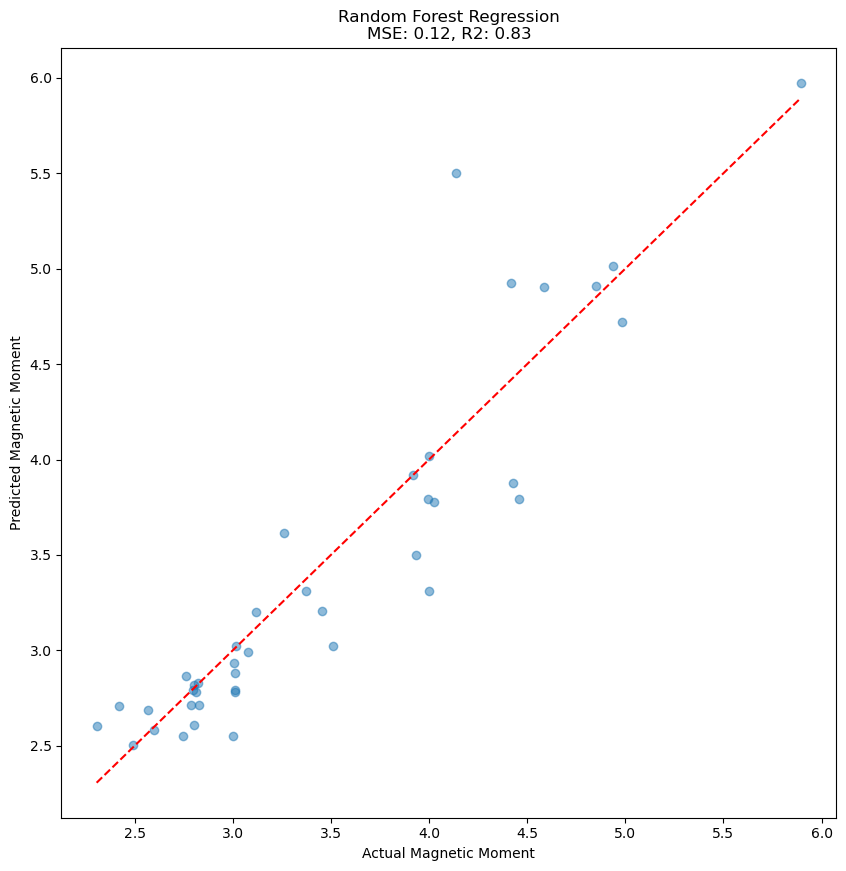

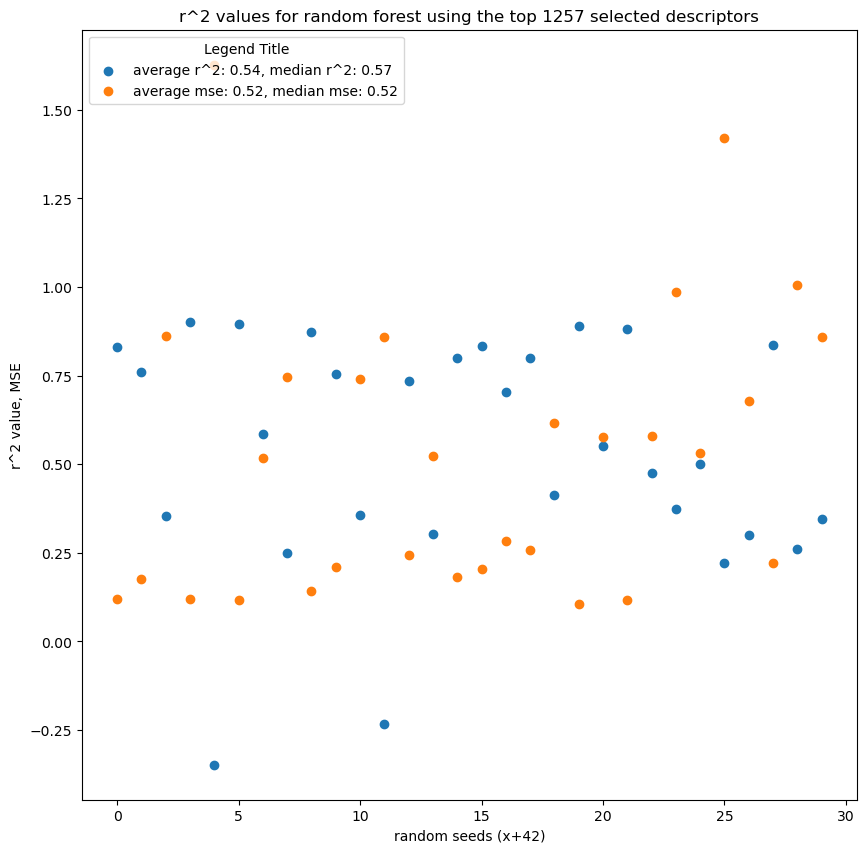

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statistics


Xhere = X_selected
print(Xhere.shape)
yhere = df4['magnetic_moment']
print(Xhere.shape, yhere.shape)
# Split the data into training and testing sets
mses = []
r2s = []
xs = [i for i in range(30)]
for i in range(30):
    
    X_train, X_test, y_train, y_test = train_test_split(Xhere, yhere, test_size=0.2, random_state=(42+i))

    # Initialize the Random Forest Regressor
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train the Random Forest Regressor
    rf_regressor.fit(X_train, y_train)

    # Generate predictions
    y_pred = rf_regressor.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mses.append(mse)
    r2s.append(r2)

    if i == 0:
        plt.figure(figsize=(10, 10))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

        plt.xlabel('Actual Magnetic Moment')
        plt.ylabel('Predicted Magnetic Moment')
        plt.title(f'Random Forest Regression\nMSE: {mse:.2f}, R2: {r2:.2f}')
        plt.show()
r2_avg = sum(r2s)/len(r2s)
r2_median = statistics.median(r2s)
mse_avg = sum(mses)/len(mses)
mse_median = statistics.median(mses)
#plot the errors and r2s
plt.figure(figsize=(10, 10))
plt.scatter(xs, r2s, label=f"average r^2: {r2_avg:.2f}, median r^2: {r2_median:.2f}")
plt.scatter(xs, mses, label=f"average mse: {mse_avg:.2f}, median mse: {mse_median:.2f}")
plt.xlabel('random seeds (x+42)')
plt.ylabel('r^2 value, MSE')
plt.title(f'r^2 values for random forest using the top {k} selected descriptors')
plt.legend(loc='upper left', title='Legend Title')
# Plot the predictions

# plt.figure(figsize=(10, 10))
# plt.scatter(y_test, y_pred, alpha=0.5)
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

# plt.xlabel('Actual Magnetic Moment')
# plt.ylabel('Predicted Magnetic Moment')
# plt.title(f'Random Forest Regression\nMSE: {mse:.2f}, R2: {r2:.2f}')
# plt.show()



In [21]:
# Print feature importances
feature_importances = rf_regressor.feature_importances_

# Sort the importances in descending order and get the corresponding feature indices
sorted_indices = np.argsort(feature_importances)[::-1]

# Print the feature names and their importances
for i in sorted_indices:
    print(f"Feature {i}: {X_selected.columns[i]} - Importance: {feature_importances[i]}")
#top_n = 10

# # Get the top N features
# top_features = feature_importance_df.head(top_n)
# plt.figure(figsize=(10, 10))
# plt.bar(top_features['Feature'], top_features['Importance'])
# plt.xlabel('Feature')
# plt.ylabel('Importance')
# plt.title(f'Top {top_n} Feature Importances')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

Feature 196: (atomic_radA2-covalent_radA2)/(exp((maxSA1+maxDA2)**2)) - Importance: 0.17944906091808085
Feature 6: (covalent_radA2-atomic_radX)/(exp((maxSB2+maxDX)**2)) - Importance: 0.0638437893088777
Feature 656: (n_val_singleA2)/(exp((maxDA1+maxSA2)**2)) - Importance: 0.058326064669889675
Feature 666: (n_val_singleA2-n_val_singleX)/(exp((maxDA1+maxSA2)**2)) - Importance: 0.05267360142846883
Feature 671: (n_val_singleA2+n_val_singleX)/(exp((maxDA1+maxSA2)**2)) - Importance: 0.05091184880916876
Feature 959: (covalent_radA2-atomic_radX)/(exp((maxSA1+maxSA2)**2)) - Importance: 0.03776991838952796
Feature 922: (covalent_radA2-covalent_radX)/(exp((maxSA1+maxSA2)**2)) - Importance: 0.03719068668720543
Feature 652: (covalent_radA2-covalent_radX)/(exp((maxPA1+maxPA2)**2)) - Importance: 0.03082952180284094
Feature 178: (covalent_radA1-covalent_radA2)/(exp((maxSA1+maxDA2)**2)) - Importance: 0.01882583673109385
Feature 764: (covalent_radA2-atomic_radX)/(exp((maxPA1+maxPA2)**2)) - Importance: 0.0

In [73]:
#open the other DF, then read the 29 descriptors into each thing, shouldnt take long
dfn = pd.read_csv('maxrad.csv', converters=converters)
#display(df.head(1))

names_to_keep = dfn['elem_frac'].tolist()

#remove 21 faulty materials
#display(df.iloc[55:66])
#-----------------------------------------------------------------------------------------------------

df3 = pd.read_csv('magneticmoment_Ef_data.csv', converters=converters)
pd.set_option('display.max_columns', None)
dfq = df3
#remove 21 faulty materials
dfq = dfq[dfq['elem_frac'].isin(names_to_keep)]
print(len(dfq))
print(dfq.shape)
tmp = []
for j in range(len(dfq.columns)):
    if( not (isinstance(dfq.iloc[0][j], np.float64) or isinstance(dfq.iloc[0][j], np.int64)) ):
        tmp.append(dfq.columns[j])

#print(tmp)
dfq = dfq.drop(columns=tmp)
print(dfq.shape)
dfq = dfq.drop(columns=["formation_energy", 'Unnamed: 0'])
print(dfq.shape)
print(dfq.columns)

205
(205, 83)
(205, 73)
(205, 71)
Index(['energy', 'magnetic_moment', 'spin_index', 'num_p', 'num_d', 'num_f',
       'atomic_rad_sum_dif', 'atomic_rad_std_dif', 'atomic_rad_std',
       'atomic_rad_avg', 'atomic_rad_max_dif', 'atomic_vol_sum_dif',
       'atomic_vol_std_dif', 'atomic_vol_std', 'atomic_vol_avg',
       'atomic_vol_max_dif', 'covalentrad_sum_dif', 'covalentrad_std_dif',
       'covalentrad_std', 'covalentrad_avg', 'covalentrad_max_dif',
       'dipole_sum_dif', 'dipole_std_dif', 'dipole_std', 'dipole_avg',
       'dipole_max_dif', 'eaffinity_sum_dif', 'eaffinity_std_dif',
       'eaffinity_std', 'e_affinity_avg', 'e_affinity_max_dif',
       'numelectron_sum_dif', 'numelectron_std_dif', 'numelectron_std',
       'numelectron_avg', 'numelectron_max_dif', 'vdwradius_sum_dif',
       'vdwradius_std_dif', 'vdwradius_std', 'vdwradius_avg',
       'vdwradius_max_dif', 'e_negativity_sum_dif', 'e_negativity_std_dif',
       'e_negativity_std', 'e_negativity_avg', 'e_negativity_

In [74]:
#display(dfq.head(1))
df_joined = dfq.copy()
for i in sorted_indices:
    curnam = X_selected.columns[i]
    #print(X_selected.columns[i])
    df_joined[curnam] = X_selected[X_selected.columns[i]]
#display(df_joined.head(1))




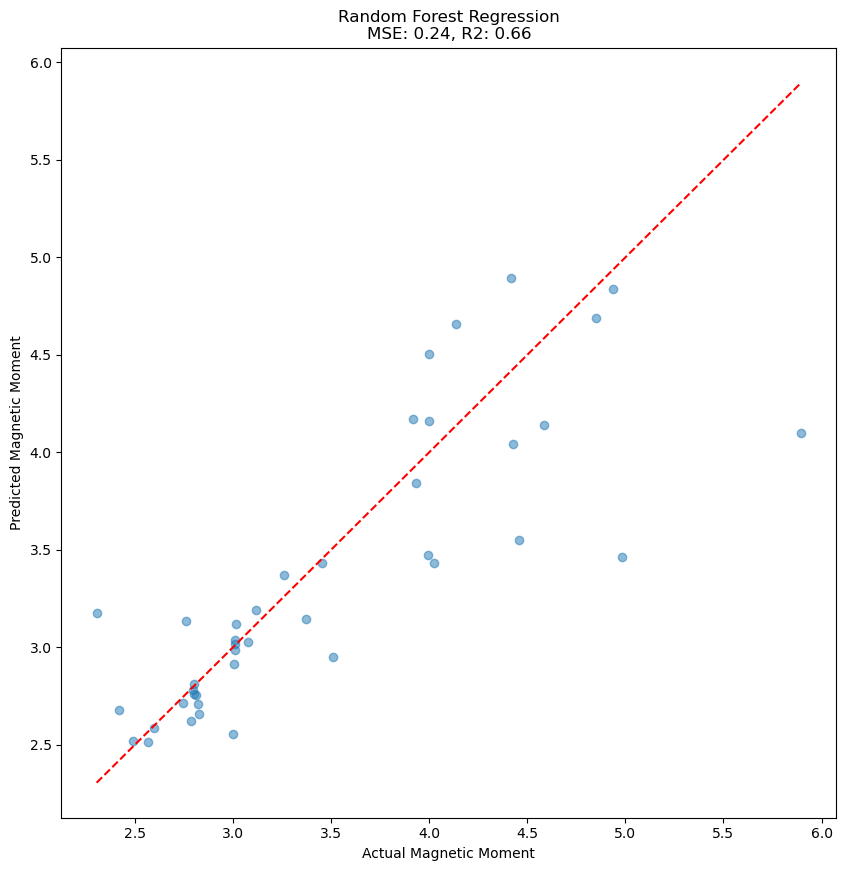

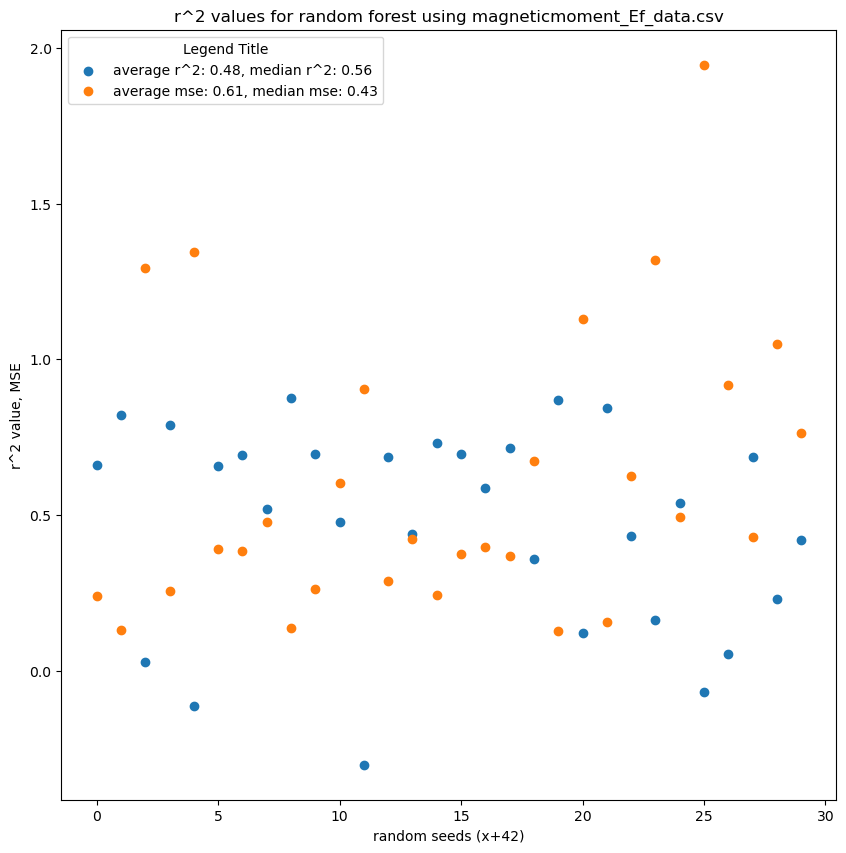

In [92]:
#display(dfq.head(1))
normal_df = dfq.copy()
enhanced_df = df_joined.copy()
normal_y = df_joined['magnetic_moment']
enhanced_y = df_joined['magnetic_moment']
normal_x = normal_df #["magnetic_moment"]#normal_x.drop("magnetic_moment", axis=1, inplace=True)
normal_x.drop("magnetic_moment", axis=1, inplace=True)
enhanced_x =  enhanced_df #["magnetic_moment"]#enhanced_df.drop("magnetic_moment", axis=1, inplace=True)
enhanced_x.drop("magnetic_moment", axis=1, inplace=True)
enhanced_x = enhanced_x.fillna(0)

# Split the data into training and testing sets
#print(normal_df.shape, normal_y.shape)
mses = []
r2s = []
xs = [i for i in range(30)]
for i in range(30):
    
    X_train, X_test, y_train, y_test = train_test_split(enhanced_x, enhanced_y, test_size=0.2, random_state=(42+i))

    # Initialize the Random Forest Regressor
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)




   

    rf_regressor.fit(X_train, y_train)

    # Generate predictions
    y_pred = rf_regressor.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mses.append(mse)
    r2s.append(r2)

    if i == 0:
        plt.figure(figsize=(10, 10))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

        plt.xlabel('Actual Magnetic Moment')
        plt.ylabel('Predicted Magnetic Moment')
        plt.title(f'Random Forest Regression\nMSE: {mse:.2f}, R2: {r2:.2f}')
        plt.show()
r2_avg = sum(r2s)/len(r2s)
r2_median = statistics.median(r2s)
mse_avg = sum(mses)/len(mses)
mse_median = statistics.median(mses)
#plot the errors and r2s
plt.figure(figsize=(10, 10))
plt.scatter(xs, r2s, label=f"average r^2: {r2_avg:.2f}, median r^2: {r2_median:.2f}")
plt.scatter(xs, mses, label=f"average mse: {mse_avg:.2f}, median mse: {mse_median:.2f}")
plt.xlabel('random seeds (x+42)')
plt.ylabel('r^2 value, MSE')
plt.title(f'r^2 values for random forest using magneticmoment_Ef_data.csv')
plt.legend(loc='upper left', title='Legend Title')
# Plot the predictions



In [ ]:

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import metrics
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

def hyper_param_search(model,param_grid,X_train,y_train,**kwargs):

   grid_clf = GridSearchCV(model, param_grid, **kwargs)
   grid_clf.fit(X_train, y_train)
   results_df=pd.DataFrame(grid_clf.cv_results_)
   results_df=pd.concat([results_df.drop(['params'], axis=1), pd.json_normalize(results_df['params'])], axis=1)
   return grid_clf,results_df

def train_and_eval_regressor(model_type,X_train,y_train,X_test,y_test,model_params={},cross_val_fold=7,do_print=True):
   model=model_type(**model_params)
   model.fit(X_train,y_train)

   y_predtrain=model.predict(X_train)
   train_r2=metrics.r2_score(y_train,y_predtrain)
   train_mae=metrics.mean_absolute_error(y_train,y_predtrain)

   y_predt=model.predict(X_test)
   test_r2=metrics.r2_score(y_test,y_predt)
   test_mae=metrics.mean_absolute_error(y_test,y_predt)

   if do_print:
       print(f"R^2 Train: {train_r2}")
       print(f"MAE Train: {train_mae}")
       print(f"R^2 Val: {test_r2}")
       print(f"MAE Val: {test_mae}")

       cv_scores=cross_val_score(model, X_train, y_train, cv=cross_val_fold, scoring='r2')
       print(f"{cross_val_fold}-fold cv: average R^2 = {cv_scores.mean()}, std = {cv_scores.std()}")
       cv_scores_mae=cross_val_score(model, X_train, y_train, cv=cross_val_fold, scoring='neg_mean_absolute_error')
       print(f"{cross_val_fold}-fold cv: average mae = {cv_scores_mae.mean()}, std = {cv_scores_mae.std()}")

   return model,y_predt,y_predtrain,test_r2,train_r2

y=yhere
X=Xhere
from sklearn.model_selection import train_test_split



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=(42+i))

from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor

model_type=ExtraTreesRegressor

param_grid = {
                 'n_estimators': range(32,70,5),
                 'max_depth': [2,4,6,8,10,12,14,16],
                 'max_features':[1,2,3,4,6,8,10,12,15,20],
                 'min_samples_split':[2, 5, 10],
                'min_samples_leaf':[1, 2, 4]
             }

clf=model_type()

grid_clf,grid_df=hyper_param_search(clf,param_grid,X_train,y_train,cv=7,verbose=10,n_jobs=6)
best_params=grid_clf.best_params_

model,y_predt,y_predtrain,_,_=train_and_eval_regressor(model_type,X_train,y_train,X_test,y_test,model_params=best_params)

pd.DataFrame(data={"mat":y_test.index,"pred":y_predt}).to_csv("pred.csv")


Fitting 7 folds for each of 5760 candidates, totalling 40320 fits
R^2 Train: 0.8031600260089466
MAE Train: 0.1999861436170739
R^2 Val: 0.2535955998627357
MAE Val: 0.45720263273904244
7-fold cv: average R^2 = 0.6354980677424257, std = 0.4415814119031882
7-fold cv: average mae = -0.30006832429152874, std = 0.15280112846844632


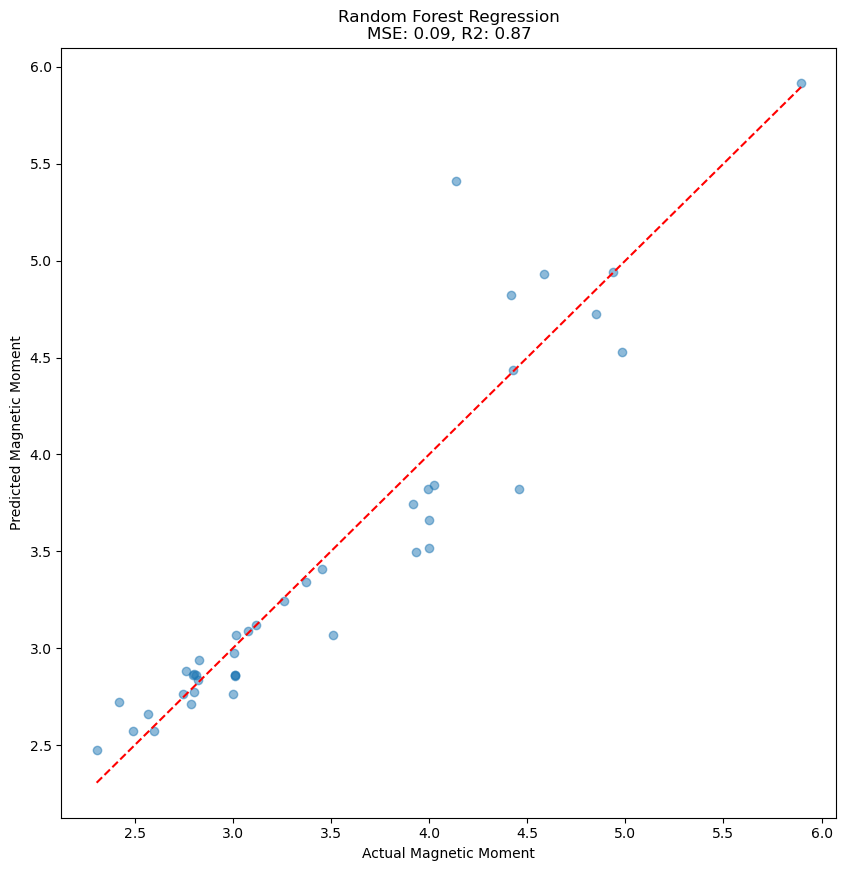

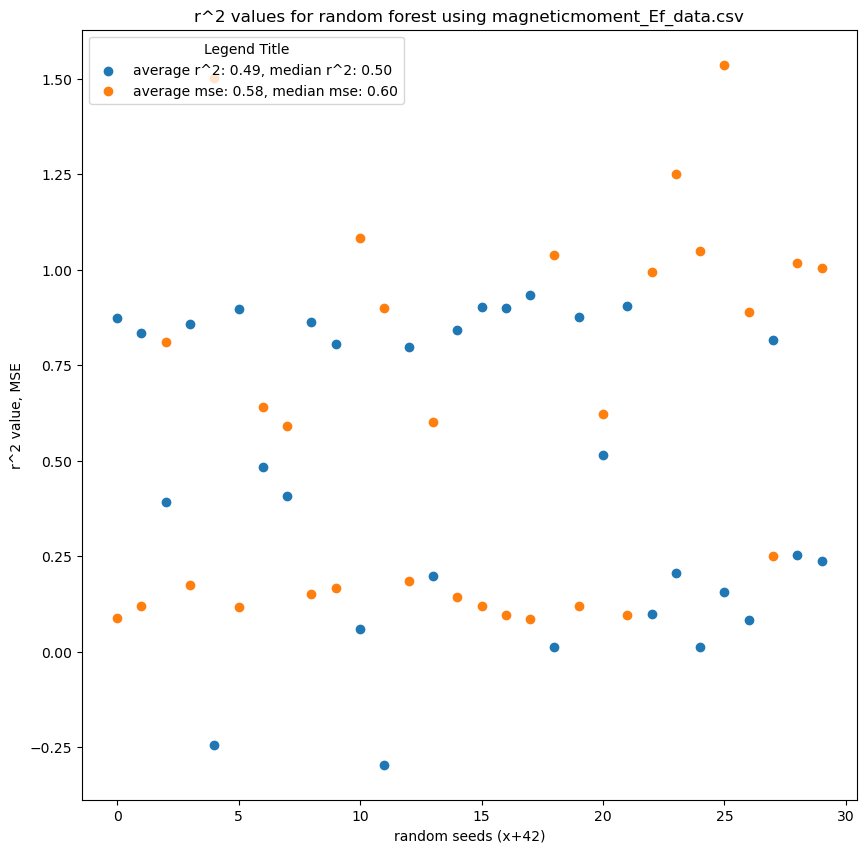

In [131]:
# Split the data into training and testing sets
#print(normal_df.shape, normal_y.shape)
mses = []
r2s = []
xs = [i for i in range(30)]
for i in range(30):
    
    X_train, X_test, y_train, y_test = train_test_split(Xhere, yhere, test_size=0.2, random_state=(42+i))

    # Initialize the Random Forest Regressor
    rf_regressor = model



   

    rf_regressor.fit(X_train, y_train)

    # Generate predictions
    y_pred = rf_regressor.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mses.append(mse)
    r2s.append(r2)

    if i == 0:
        plt.figure(figsize=(10, 10))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

        plt.xlabel('Actual Magnetic Moment')
        plt.ylabel('Predicted Magnetic Moment')
        plt.title(f'Random Forest Regression\nMSE: {mse:.2f}, R2: {r2:.2f}')
        plt.show()
r2_avg = sum(r2s)/len(r2s)
r2_median = statistics.median(r2s)
mse_avg = sum(mses)/len(mses)
mse_median = statistics.median(mses)
#plot the errors and r2s
plt.figure(figsize=(10, 10))
plt.scatter(xs, r2s, label=f"average r^2: {r2_avg:.2f}, median r^2: {r2_median:.2f}")
plt.scatter(xs, mses, label=f"average mse: {mse_avg:.2f}, median mse: {mse_median:.2f}")
plt.xlabel('random seeds (x+42)')
plt.ylabel('r^2 value, MSE')
plt.title(f'r^2 values for random forest using magneticmoment_Ef_data.csv')
plt.legend(loc='upper left', title='Legend Title')
# Plot the predictions